In [4]:
import pickle
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import logomaker
import pandas as pd
import os


In [5]:
path_res = Path(os.getcwd()) / "results/inference_results"
path = path_res / "inference_results.pickle"  
with open(path, "rb") as f:
    results = pickle.load(f)

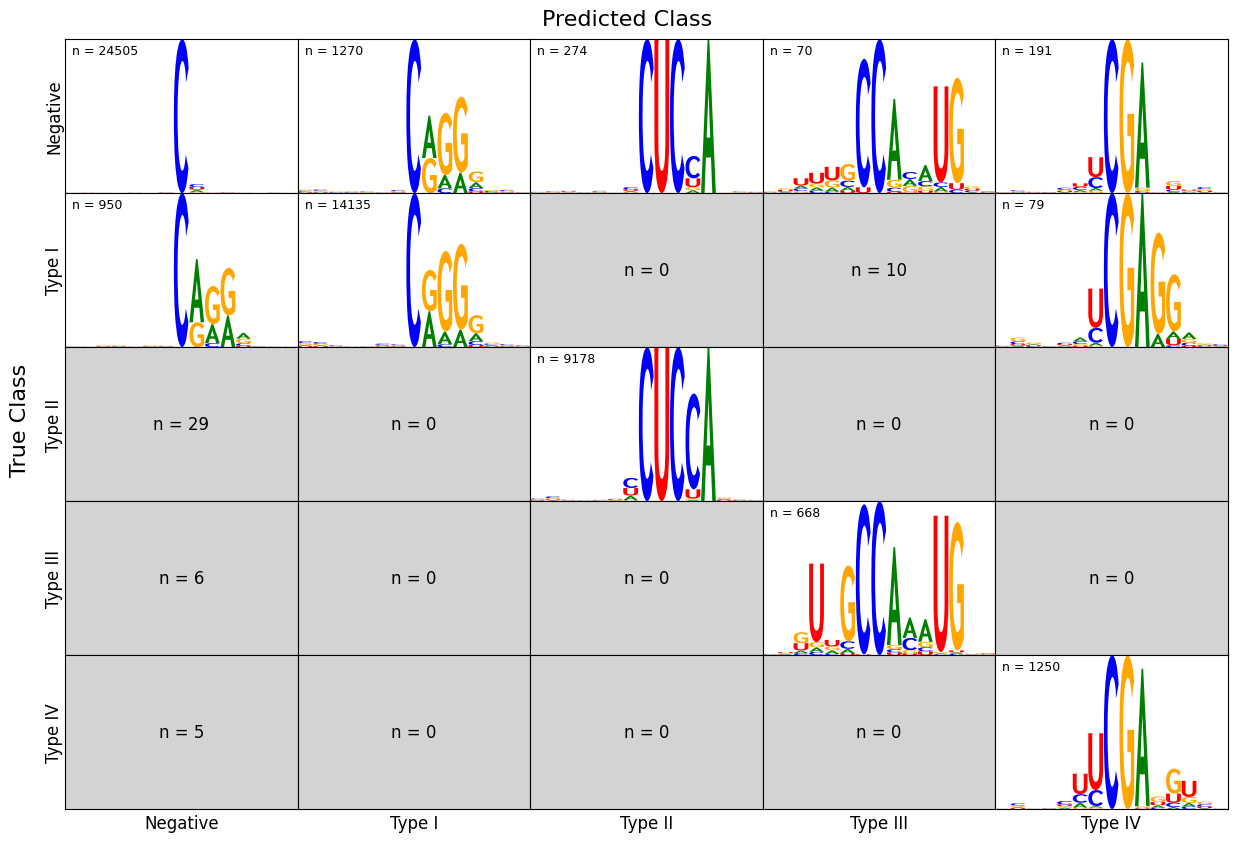

In [ ]:

model = "RNN"

probabilities_test = results["test_set"][model]["all_probs"]
labels_test = results["test_set"][model]["all_labels"]
input_ids_test = results["test_set"][model]["input_ids"]

probabilities_training = results["training_set"][model]["all_probs"]
labels_training = results["training_set"][model]["all_labels"]
input_ids_training = results["training_set"][model]["input_ids"]

probabilities = np.vstack((probabilities_test, probabilities_training))
labels = np.concatenate((labels_test, labels_training))
input_ids = np.vstack((input_ids_test, input_ids_training))


n = 5
fig, axes = plt.subplots(n, n,
                         figsize=(n*3, n*2),
                         sharex=False, sharey=False)
fig.subplots_adjust(hspace=0, wspace=0)

class_names = ["Negative", "Type I", "Type II", "Type III", "Type IV"]
n = len(class_names)
for i in range(n):
    for j in range(n):

        ax = axes[i,j]
        ax.set_xticks([])
        ax.set_yticks([])
        if i == n-1: ax.set_xlabel(class_names[j], rotation=0, va="center", labelpad=10, fontsize=12)
        if j == 0:  ax.set_ylabel(class_names[i], rotation=90, va="center", labelpad=8, fontsize=12)

        idxs = np.where((labels == i) & (np.argmax(probabilities, axis=1) == j))[0]
        if len(idxs) < 50:
            #color in gray
            ax.set_facecolor("lightgray")
            ax.text(0.5, 0.5, f"n = {len(idxs)}", ha='center', va='center', fontsize=12)
            continue
        current = input_ids[idxs]
        pwm = np.sum(current, axis=0) / np.sum(np.sum(current, axis=0), axis=-1).reshape(-1, 1)
        pwm = pwm[pwm.shape[0]//2 - 7: pwm.shape[0]//2 + 8]
        pwm = pwm + 1e-9
        pwm = pwm / np.sum(pwm, axis=-1).reshape(-1, 1)
        pwm = pd.DataFrame(pwm, columns=["A","C","G","U"])
        info_df = logomaker.transform_matrix(pwm,
                                     from_type='probability',
                                     to_type='information')
        


        logo = logomaker.Logo(info_df, ax=ax, font_name='inconsolata',)

        ax.text(0.0, 1.8, f"n = {len(idxs)}",fontsize=9)


fig.text(0.5, 0.9, "Predicted Class", ha='center', va='center', fontsize=16)  # bottom center
fig.text(0.095, 0.5, "True Class", ha='center', va='center', rotation='vertical', fontsize=16)  # left center   

#save pdf
path_save_pdf = path_res / f"confusion_matrix_{model}.pdf" 
path_save_eps = path_res / f"confusion_matrix_{model}.eps"
# plt.savefig(path_save_pdf, bbox_inches='tight')
plt.savefig(path_save_eps, bbox_inches='tight')